# NIHCXR Synthetic Drift - Gaussian Shift

## Load Libraries

In [32]:
from drift_detection.drift_detector import (
    Detector,
    Experimenter,
    Reductor,
    SyntheticShiftApplicator,
    TSTester,
    plot_drift_samples_pval,
)
from drift_detection.datasets import NIHCXRDataset
from drift_detection.drift_detector.utils import Loader

## Query Data

In [33]:
# Load the dataset
dataset = NIHCXRDataset(cfg_path="../../datasets/configs/nihcxr.yaml")
dataset, metadata, metadata_mapping = dataset.get_data()

Setting XRayResizer engine to cv2 could increase performance.


## Initalize Reductor, Tester & Detector

In [34]:
reductor = Reductor(
    dr_method="TAE_txrv_CNN",
)

tester = TSTester(
    tester_method="mmd",
)


detector = Detector(
    reductor=reductor,
    tester=tester,
)
with Loader("Initializing the detector..."):
    detector.fit(dataset, progress=False)

Done!                                                                           


## Setup Baseline Experiment

In [35]:
baseline_experiment = Experimenter(
    "sensitivity_test",
    detector=detector,
)

## Setup Drift Experiment (Categorical Shift)

In [36]:
shiftapplicators = []
shift_type = ["categorical_shift"]*3
cat_col = ["gender", "view", "age"]
target_categories = ["M", "PA", "0-18"]

for s_type, col, target in zip(shift_type, cat_col, target_categories):
    shiftapplicators.append(
        SyntheticShiftApplicator(
            shift_type=s_type,
            categorical_column=col,
            target_category=target,
        )
    )

experiments = []
for shiftapplicator in shiftapplicators:
    drift_experiment = Experimenter(
        "sensitivity_test",
        detector=detector,
        shiftapplicator=shiftapplicator,
    )
    experiments.append(drift_experiment)

## Run Experiments

In [37]:
baseline_results = baseline_experiment.run(dataset, metadata, metadata_mapping)
drift_results = []
for experiment in experiments:
    drift_results.append(experiment.run(dataset, metadata, metadata_mapping))

100%|██████████| 35/35 [00:37<00:00,  1.06s/it]


## Gather Results

In [38]:
results_dict = {}
results_dict.update({"baseline": baseline_results})
for itr, result in enumerate(drift_results):
    results_dict.update({f"{cat_col[itr]}: {target_categories[itr]}": result})

## Plot Experimental Results

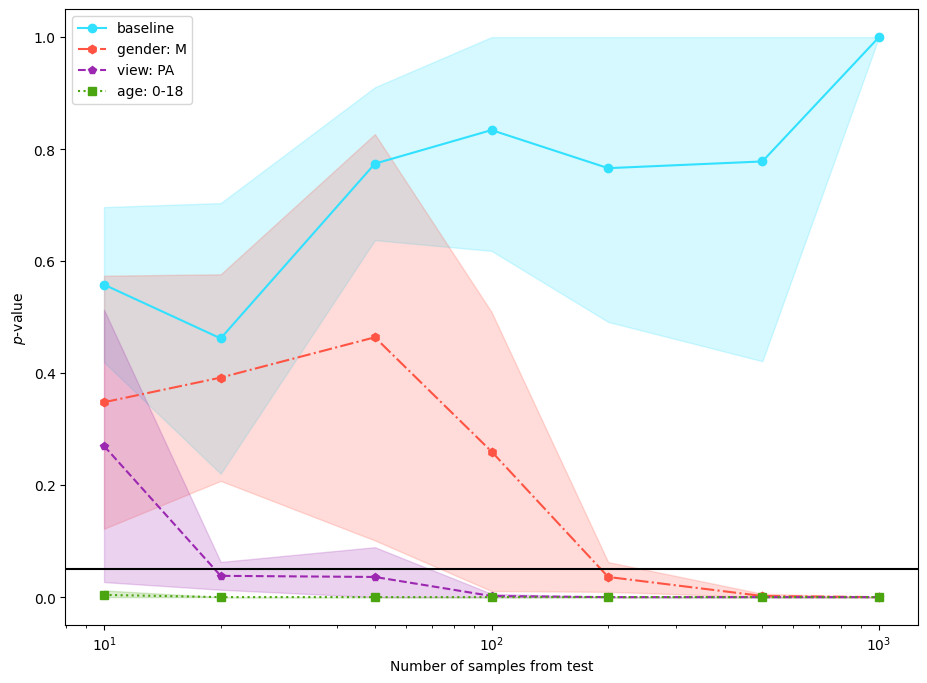

In [39]:
plot_drift_samples_pval(results_dict, 0.05)